Just run all the cell one by one to repeat the results

# Deep Convolutional Generative Adversarial Network

In [15]:
import os
import sys
import datetime
pwd = os.getcwd()
sys.path.append(pwd)

import pickle
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

from utils.models import Attention56
from tensorflow.keras import optimizers, losses, callbacks
print("%d GPUs are available for tensorflow %s in current environment." % 
      (len(tf.config.experimental.list_physical_devices('GPU')), tf.__version__))
# %load_ext tensorboard

1 GPUs are available for tensorflow 2.0.0 in current environment.
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Set the Paths of the Outputs

In [16]:
# config the version of training, structure of model and usage of dataset
# i.e. the identifier of a specific model
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
structure = 'RAN56'
dataset = 'CIFAR10'
config = "%s-%s-%s" % (structure, dataset, stamp)
config

'RAN56-CIFAR10-20191214-030916'

In [ ]:
# set and create the path for log file for tesnorboard
log_dir = os.path.join(pwd, 'outputs', 'logs')
os.makedirs(log_dir, exist_ok = True)
# set and create the path for saving the images
image_dir = os.path.join(pwd, 'outputs', 'images')
os.makedirs(os.path.join(image_dir, config), exist_ok = True)
# set and create the path for saving the weights of the model
checkpoint_dir = os.path.join(pwd, 'outputs', 'checkpoints')
os.makedirs(checkpoint_dir, exist_ok = True)
os.makedirs(os.path.join(checkpoint_dir, config), exist_ok = True)

### Load and Prepare the Dataset

In [ ]:
# normalize cifar10 data
def preprocess_cifar10(x, y):        
    x = 2*tf.cast(x, dtype=tf.float32)/255 - 1
    y = tf.squeeze(tf.one_hot(y, depth=10, dtype=tf.int32))
    return x, y
# normalize cifar100 data
def preprocess_cifar100(x, y):        
    x = 2*tf.cast(x, dtype=tf.float32)/255 - 1
    y = tf.one_hot(y, depth=100, dtype=tf.int32)
    return x, y
# augment the data if needed
def augment(x, y):
    x = tf.image.random_flip_up_down(x)
    x = tf.image.random_flip_left_right(x)
    return x, y

In [19]:
if 'CIFAR10' in config:
    # load and preprocess cifer 10 data
    (cifar10_train_x, cifar10_train_y), (cifar10_val_x, cifar10_val_y) = keras.datasets.cifar10.load_data()
    train_db = tf.data.Dataset.from_tensor_slices((cifar10_train_x, cifar10_train_y)).map(preprocess_cifar10).shuffle(100000)
    val_db = tf.data.Dataset.from_tensor_slices((cifar10_val_x, cifar10_val_y)).map(preprocess_cifar10)
else:
    # # load and preprocess cifer 100 data
    (cifar100_train_x, cifar100_train_y), (cifar100_val_x, cifar100_val_y) = keras.datasets.cifar100.load_data()
    train_db = tf.data.Dataset.from_tensor_slices((cifar100_train_x, cifar100_train_y)).map(preprocess_cifar100).shuffle(100000)
    val_db = tf.data.Dataset.from_tensor_slices((cifar100_val_x, cifar100_val_y)).map(preprocess_cifar100)

# data augmentation
train_db = train_db.map(augment)
# get one batch and check the dimension of this batch
samples = next(iter(val_db.batch(8)))
print("shape of one batch for CIFAR10 images is: %s and %s" % 
    (str(samples[0].shape), str(samples[1].shape)))

shape of one batch for CIFAR10 images is: (8, 32, 32, 3) and (8, 10)


### Load and Define a Residual Attention Network

#### Set the Hyper-Parameters
There are lots of hyper-parameters defined in the models,py

In [ ]:
# number of epochs
EPOCH = 300
BATCH = 128
VALID = 1
LEARNING_RATE = 1e-3
RESTORE = None

#### Set the Callbacks

In [ ]:
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
loss = losses.CategoricalCrossentropy(from_logits=True)

# object to save the training history
history = callbacks.History()
# set the early stopping
earlystopping = callbacks.EarlyStopping(patience=20, 
                                        monitor='val_accuracy', 
                                        verbose=0)
# set the tensorboard to visualize
tensorboard = callbacks.TensorBoard(log_dir=os.path.join(log_dir, config), 
                                    histogram_freq=2)
# set the learning rate decay
decay = callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                    factor=0.6, 
                                    patience=10, 
                                    min_lr=1e-6, 
                                    verbose=0)
# set the way of saving a model
save = callbacks.ModelCheckpoint(filepath=os.path.join(checkpoint_dir, config, "model.h5"),
                                 save_best_only=True, 
                                 monitor='val_accuracy', 
                                 verbose=0)

callback = [history, earlystopping, tensorboard, decay, save]

#### Initialize and train the mode

In [24]:
model = Attention56(config)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
if RESTORE:
  model.load_weights(os.path.join(checkpoint_dir, RESTORE, "ckpt"))
model.build((None, 32, 32, 3))
model.summary()

Model: "attention56_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_86 (Conv2D)           multiple                  304       
_________________________________________________________________
residual_unit_between_2 (Res multiple                  360       
_________________________________________________________________
attention_module_3 (Attentio multiple                  38496     
_________________________________________________________________
residual_unit_between_3 (Res multiple                  6240      
_________________________________________________________________
attention_module_4 (Attentio multiple                  382208    
_________________________________________________________________
residual_unit_34 (ResidualUn multiple                  14368     
_________________________________________________________________
attention_module_5 (Attentio multiple                

In [25]:
model.fit(train_db.batch(BATCH),
          epochs=EPOCH, 
          validation_freq=VALID,
          validation_data=val_db.batch(BATCH*5), 
          callbacks=callback)

Epoch 1/300
391/391 [==============================] - 45s 115ms/step - loss: 2.1338 - accuracy: 0.3097 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/300
391/391 [==============================] - 32s 82ms/step - loss: 1.7314 - accuracy: 0.4176 - val_loss: 1.7717 - val_accuracy: 0.3866
Epoch 3/300
391/391 [==============================] - 32s 82ms/step - loss: 1.5379 - accuracy: 0.4717 - val_loss: 1.5688 - val_accuracy: 0.4565
Epoch 4/300
391/391 [==============================] - 31s 80ms/step - loss: 1.4188 - accuracy: 0.5068 - val_loss: 1.5033 - val_accuracy: 0.4741
Epoch 5/300
391/391 [==============================] - 32s 83ms/step - loss: 1.3236 - accuracy: 0.5378 - val_loss: 1.3955 - val_accuracy: 0.5089
Epoch 6/300
391/391 [==============================] - 32s 82ms/step - loss: 1.2480 - accuracy: 0.5633 - val_loss: 1.3827 - val_accuracy: 0.5233
Epoch 7/300
391/391 [==============================] - 32s 83ms/step - loss: 1.1868 - accuracy: 0.5853 - val_loss: 1.1908

In [ ]:
# save the training history
with open(os.path.join(image_dir, config, 'history.pkl'),"wb") as writer:
    pickle.dump(history.history, writer)

### Visualization

#### Tensorboard
![title](outputs/images/RAN56-CIFAR10-20191214-041151/tensorboard.png)

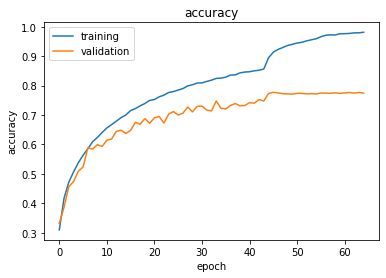

In [44]:
data = history.history
fig, ax = plt.subplots()
ax.plot(data['accuracy'], label='training')
ax.plot(data['val_accuracy'], label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title('accuracy')
ax.legend()
fig.savefig(os.path.join(image_dir, config,'accuracy.png'))

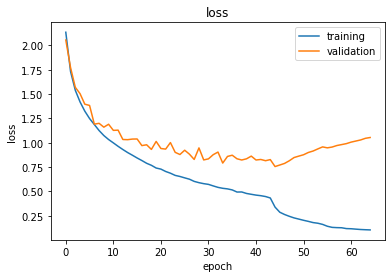

In [43]:
fig, ax = plt.subplots()
ax.plot(data['loss'], label='training')
ax.plot(data['val_loss'], label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('loss')
ax.legend()
fig.savefig(os.path.join(image_dir, config,'loss.png'))